In [1]:
import gym
import numpy as np
from stable_baselines3 import PPO
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.evaluation import evaluate_policy

import quadrotor_env

In [2]:

env = gym.make('Quadrotor-v0')
vec_env = make_vec_env(lambda: env, n_envs=1)


/Users/akashvallamsetty/Desktop/rl final project/akash/rlvenv/lib/python3.12/site-packages/gym/spaces/box.py:127: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")
/Users/akashvallamsetty/Desktop/rl final project/akash/rlvenv/lib/python3.12/site-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


In [3]:
from stable_baselines3.common.callbacks import BaseCallback
import matplotlib.pyplot as plt

class RewardLoggingCallback(BaseCallback):

    def __init__(self, verbose=1):
        super(RewardLoggingCallback, self).__init__(verbose)
        self.episode_rewards = []

    def _on_step(self) -> bool:
       
        if 'episode' in self.locals['infos'][0].keys():
            self.episode_rewards.append(self.locals['infos'][0]['episode']['r'])
        return True

    def _on_training_end(self):
        
        plt.figure(figsize=(10, 5))
        plt.plot(self.episode_rewards)
        plt.xlabel('Episode')
        plt.ylabel('Average Reward')
        plt.title('Average Reward vs. Episode')
        plt.grid(True)
        plt.show()

# Usage:
callback = RewardLoggingCallback()


Using cpu device
Logging to ./quadrotor_tensorboard/PPO_65


/Users/akashvallamsetty/Desktop/rl final project/akash/rlvenv/lib/python3.12/site-packages/gym/utils/passive_env_checker.py:174: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed a `seed` instead of using `Env.seed` for resetting the environment random number generator.
  logger.warn(
/Users/akashvallamsetty/Desktop/rl final project/akash/rlvenv/lib/python3.12/site-packages/gym/utils/passive_env_checker.py:187: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed `options` to allow the environment initialisation to be passed additional information.
  logger.warn(
/Users/akashvallamsetty/Desktop/rl final project/akash/rlvenv/lib/python3.12/site-packages/gym/utils/passive_env_checker.py:195: UserWarning: WARN: The result returned by `env.reset()` was not a tuple of the form `(obs, info)`, where `obs` is a observation and `info` is a dictionary containing additional information. Actual type: `<class 'numpy.ndarray'>`
  logger.

----------------------------------
| rollout/           |           |
|    ep_len_mean     | 100       |
|    ep_rew_mean     | -3.24e+03 |
| time/              |           |
|    fps             | 4086      |
|    iterations      | 1         |
|    time_elapsed    | 0         |
|    total_timesteps | 2048      |
----------------------------------
----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 100        |
|    ep_rew_mean          | -3.24e+03  |
| time/                   |            |
|    fps                  | 1903       |
|    iterations           | 2          |
|    time_elapsed         | 2          |
|    total_timesteps      | 4096       |
| train/                  |            |
|    approx_kl            | 0.66514456 |
|    clip_fraction        | 0.752      |
|    clip_range           | 0.2        |
|    entropy_loss         | -5.15      |
|    explained_variance   | 0.00152    |
|    learning_rate        | 0.003  

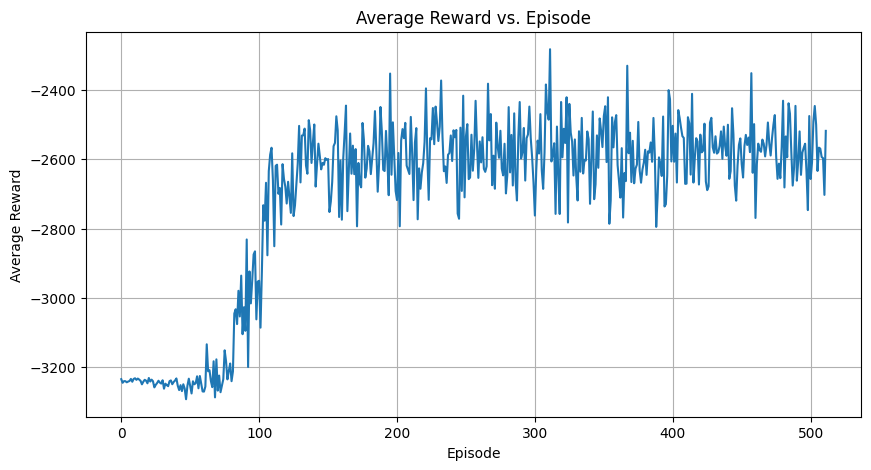

In [4]:
# Instantiate the agent
model = PPO("MlpPolicy", vec_env, verbose=1, tensorboard_log="./quadrotor_tensorboard/",
            learning_rate=0.003, n_steps=2048, batch_size=32, n_epochs=10,
            gamma=0.99, gae_lambda=0.95, clip_range=0.2, ent_coef=0.3, vf_coef=0.5)

reward_logging_callback = RewardLoggingCallback()



total_timesteps = 200000
model.learn(total_timesteps=total_timesteps,callback=reward_logging_callback)

# Save the model
model.save("ppo_quadrotor")


In [5]:
# Reload the model (optional)
model = PPO.load("ppo_quadrotor", env=vec_env)

# Evaluate the policy
mean_reward, std_reward = evaluate_policy(model, model.get_env(), n_eval_episodes=100)
print(f"Mean reward: {mean_reward}, Std reward: {std_reward}")

# Close the environment
env.close()

Mean reward: -3214.1967520000007, Std reward: 9.094947017729282e-13


/Users/akashvallamsetty/Desktop/rl final project/akash/rlvenv/lib/python3.12/site-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


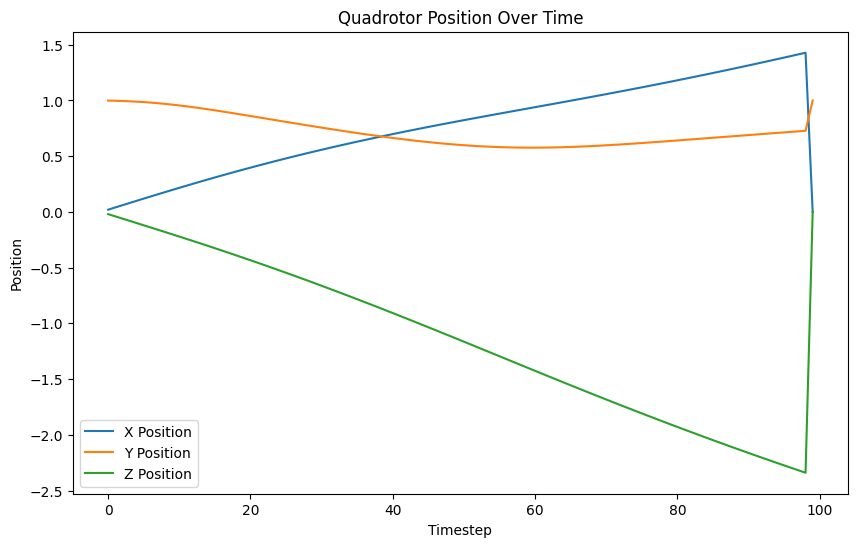

In [7]:
import gym
import matplotlib.pyplot as plt
from stable_baselines3 import PPO

# Assuming 'QuadrotorEnv' is your environment's class and it is properly registered in gym
# env = gym.make('QuadrotorEnv-v0')

# Load the model
model = PPO.load("ppo_quadrotor", env=env)

# Function to run a single episode and capture positions
def run_episode(model, env):
    obs = env.reset()
    done = False
    positions = []  # List to store positions

    while not done:
        action, _ = model.predict(obs, deterministic=True)
        obs, reward, done, info = env.step(action)
        # Assuming the state includes position at the first three indices
        positions.append(obs[:3])

    return positions

# Run the episode
positions = run_episode(model, env)

# Close the environment
env.close()

# Extract x, y, z coordinates
x_vals = [pos[0] for pos in positions]
y_vals = [pos[1] for pos in positions]
z_vals = [pos[2] for pos in positions]

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(x_vals, label='X Position')
plt.plot(y_vals, label='Y Position')
plt.plot(z_vals, label='Z Position')
plt.xlabel('Timestep')
plt.ylabel('Position')
plt.title('Quadrotor Position Over Time')
plt.legend()
plt.show()
